# Financial Planning with Monte Carlo Simulations

This program will GET price data from several APIs. We will use price data, share counts, and various personal financial data points to assess people's financial health. Next, in part 2, we will run Monte Carlo simulations to calculate portfolio returns. 

Note: Make sure to; (conda activate alpacaenv) & (include MCForecastTools in the same folder as this file)

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_response_data = requests.get(btc_url)

# pretty print btc_price so I can easily see where I need to index into to pull values
btc_data = btc_response_data.json()
print(json.dumps(btc_data, indent=8))

# now get bitcoin price and check output
btc_price = btc_data["data"]["1"]["quotes"]["USD"]["price"]
btc_price

{
        "data": {
                "1": {
                        "id": 1,
                        "name": "Bitcoin",
                        "symbol": "BTC",
                        "website_slug": "bitcoin",
                        "rank": 1,
                        "circulating_supply": 19115768,
                        "total_supply": 19115768,
                        "max_supply": 21000000,
                        "quotes": {
                                "USD": {
                                        "price": 24019.0,
                                        "volume_24h": 17895056230,
                                        "market_cap": 459193123807,
                                        "percentage_change_1h": 0.915609838435906,
                                        "percentage_change_24h": 4.49956911268867,
                                        "percentage_change_7d": 2.73308897430353,
                                        "percent_change_1h": 0.915609838435906,
  

24019.0

In [6]:
# Fetch current ETH price
eth_response_data = requests.get(eth_url)

# pretty print ethereum data so I can easily see where I need to index into to pull values
eth_data = eth_response_data.json()
print(json.dumps(eth_data, indent=8))

# now get ethereum price and check output
eth_price = eth_data["data"]["1027"]["quotes"]["USD"]["price"]
eth_price

{
        "data": {
                "1027": {
                        "id": 1027,
                        "name": "Ethereum",
                        "symbol": "ETH",
                        "website_slug": "ethereum",
                        "rank": 2,
                        "circulating_supply": 120011412,
                        "total_supply": 120011412,
                        "max_supply": 120011412,
                        "quotes": {
                                "USD": {
                                        "price": 1746.0,
                                        "volume_24h": 10359858787,
                                        "market_cap": 209346090342,
                                        "percentage_change_1h": 0.736955711228736,
                                        "percentage_change_24h": 3.80238523218962,
                                        "percentage_change_7d": 3.80426791710687,
                                        "percent_change_1h": 0.736955711

1746.0

In [7]:
# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $28822.80
The current value of your 5.3 ETH is $9253.80


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [8]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [9]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [10]:
# Format current date as ISO format
current_date = pd.Timestamp("08-05-2022", tz = "America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
ticker_data = api.get_bars(
    tickers,
    timeframe,
    start = current_date,
    end = current_date
).df

ticker_data

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-08-05 04:00:00+00:00,102.81,102.83,102.52,102.71,4847064,16418,102.711038,AGG
2022-08-05 04:00:00+00:00,409.68,414.15,409.60,413.47,56751151,455450,412.292366,SPY


In [11]:
# Reorganize the DataFrame
# Separate ticker data
AGG = ticker_data[ticker_data["symbol"] == "AGG"].drop("symbol", axis=1)
SPY = ticker_data[ticker_data["symbol"] == "SPY"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
ticker_data = pd.concat([AGG, SPY], axis=1, keys=["AGG", "SPY"])

In [12]:
# Preview DataFrame
ticker_data

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2022-08-05 04:00:00+00:00  102.81  102.83  102.52  102.71  4847064   

                                                      SPY                 \
                          trade_count        vwap    open    high    low   
timestamp                                                                  
2022-08-05 04:00:00+00:00       16418  102.711038  409.68  414.15  409.6   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-08-05 04:00:00+00:00  413.47  56751151      455450  412.292366

In [13]:
# Pick AGG and SPY close prices
agg_close_price = ticker_data["AGG"]["close"][0]
spy_close_price = ticker_data["SPY"]["close"][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $102.71
Current SPY closing price: $413.47


In [14]:
# Compute the current value of shares
my_spy_value = agg_close_price * my_agg
my_agg_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $20542.00
The current value of your 200 AGG shares is $20673.50


### Savings Health Analysis

In [15]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
df_savings_list = [(my_btc_value + my_eth_value),(my_agg_value + my_spy_value)]

# Create savings DataFrame
df_savings = pd.DataFrame(df_savings_list, index=["crypto", "shares"])
df_savings.columns = ["amount"]

# Display savings DataFrame
display(df_savings)

,amount
crypto,38076.6
shares,41215.5


<AxesSubplot:ylabel='amount'>

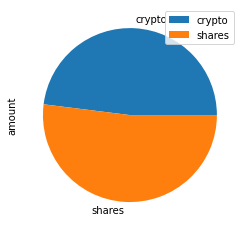

In [16]:
# Plot savings pie chart
df_savings.plot.pie(y="amount")

In [17]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = my_btc_value + my_eth_value + my_agg_value + my_spy_value\

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations! Your emergency fund is more than sufficient!")
elif total_savings == emergency_fund:
    print("Congratultions! Your emergency fund is sufficient!")
else:
    print(f"Sorry, your emergency fund has insufficient funds, please add ${emergency_fund - total_savings}.")  

Congratulations! Your emergency fund is more than sufficient!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [18]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-08-04', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-08-04', tz='America/New_York').isoformat()

In [19]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data["symbol"] == "AGG"].drop("symbol", axis=1)
SPY = df_stock_data[df_stock_data["symbol"] == "SPY"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY], axis=1, keys=["AGG", "SPY"])

# Display sample data
df_stock_data

AGG                                      \
                             open     high       low   close   volume   
timestamp                                                               
2017-08-04 04:00:00+00:00  109.70  109.720  109.5350  109.68  2300875   
2017-08-07 04:00:00+00:00  109.69  109.720  109.6066  109.67  2359826   
2017-08-08 04:00:00+00:00  109.67  109.690  109.5000  109.57  2570876   
2017-08-09 04:00:00+00:00  109.87  109.870  109.6600  109.67  2308932   
2017-08-10 04:00:00+00:00  109.70  109.850  109.6700  109.78  2004163   
...                           ...      ...       ...     ...      ...   
2022-07-29 04:00:00+00:00  103.94  104.395  103.8300  104.07  6523118   
2022-08-01 04:00:00+00:00  103.97  104.305  103.9100  104.23  7485387   
2022-08-02 04:00:00+00:00  104.27  104.345  103.1350  103.16  6866199   
2022-08-03 04:00:00+00:00  103.03  103.640  102.7200  103.62  6254853   
2022-08-04 04:00:00+00:00  103.67  103.890  103.5700  103.87  5198972   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2017-08-04 04:00:00+00:00       10411  109.656104  247.52  247.79  246.97   
2017-08-07 04:00:00+00:00        7755  109.674876  247.50  247.87  247.37   
2017-08-08 04:00:00+00:00       12663  109.577636  247.49  248.91  246.83   
2017-08-09 04:00:00+00:00       11031  109.771749  246.46  247.31  246.06   
2017-08-10 04:00:00+00:00       12437  109.776611  246.30  246.44  243.70   
...                               ...         ...     ...     ...     ...   
2022-07-29 04:00:00+00:00       22800  104.156714  407.70  413.02  406.77   
2022-08-01 04:00:00+00:00       31215  104.156518  409.16  413.41  408.40   
2022-08-02 04:00:00+00:00       38447  103.522777  409.03  413.00  406.82   
2022-08-03 04:00:00+00:00       23383  103.276553  410.40  415.68  410.00   
2022-08-04 04:00:00+00:00       17078  103.727981  414.25  415.09  412.44   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2017-08-04 04:00:00+00:00  247.41   60191838      175911  247.329155  
2017-08-07 04:00:00+00:00  247.87   31995021      100111  247.668698  
2017-08-08 04:00:00+00:00  247.26   61719353      192921  247.739709  
2017-08-09 04:00:00+00:00  247.25   62632619      223650  246.791421  
2017-08-10 04:00:00+00:00  243.76  120418270      424321  245.027847  
...                           ...        ...         ...         ...  
2022-07-29 04:00:00+00:00  411.99   86779944      544810  410.668581  
2022-08-01 04:00:00+00:00  410.77   69633616      516221  411.079113  
2022-08-02 04:00:00+00:00  408.06   63113622      502751  409.635855  
2022-08-03 04:00:00+00:00  414.45   67573063      463932  413.267159  
2022-08-04 04:00:00+00:00  414.17   45565581      364658  414.080458  

[1259 rows x 14 columns]

In [20]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stocks = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[.40, .60],
    num_simulation=500,
    num_trading_days=252 * 30
)

In [21]:
# Printing the simulation input data
MC_stocks.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-08-04 04:00:00+00:00  109.70  109.72  109.5350  109.68  2300875   
2017-08-07 04:00:00+00:00  109.69  109.72  109.6066  109.67  2359826   
2017-08-08 04:00:00+00:00  109.67  109.69  109.5000  109.57  2570876   
2017-08-09 04:00:00+00:00  109.87  109.87  109.6600  109.67  2308932   
2017-08-10 04:00:00+00:00  109.70  109.85  109.6700  109.78  2004163   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-08-04 04:00:00+00:00       10411  109.656104          NaN  247.52   
2017-08-07 04:00:00+00:00        7755  109.674876    -0.000091  247.50   
2017-08-08 04:00:00+00:00       12663  109.577636    -0.000912  247.49   
2017-08-09 04:00:00+00:00       11031  109.771749     0.000913  246.46   
2017-08-10 04:00:00+00:00       12437  109.776611     0.001003  246.30   

                                                                          \
                             high     low   close     volume trade_count   
timestamp                                                                  
2017-08-04 04:00:00+00:00  247.79  246.97  247.41   60191838      175911   
2017-08-07 04:00:00+00:00  247.87  247.37  247.87   31995021      100111   
2017-08-08 04:00:00+00:00  248.91  246.83  247.26   61719353      192921   
2017-08-09 04:00:00+00:00  247.31  246.06  247.25   62632619      223650   
2017-08-10 04:00:00+00:00  246.44  243.70  243.76  120418270      424321   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-08-04 04:00:00+00:00  247.329155          NaN  
2017-08-07 04:00:00+00:00  247.668698     0.001859  
2017-08-08 04:00:00+00:00  247.739709    -0.002461  
2017-08-09 04:00:00+00:00  246.791421    -0.000040  
2017-08-10 04:00:00+00:00  245.027847    -0.014115

In [22]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stocks.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\range\Documents\Fintech Bootcamp\Week_05_Assignment\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994884,1.002821,1.003718,0.989210,0.997464,1.009388,1.003374,0.995292,1.005673,1.009470,...,0.994135,0.990340,1.016295,1.006792,1.013000,1.001588,0.993316,0.988547,0.991227,0.994385
2,0.988013,0.998113,0.996110,0.985889,0.990216,0.996461,1.002953,0.999149,0.998306,1.010565,...,0.993035,0.998445,1.026112,1.013620,0.999058,0.996395,0.988752,0.988804,0.995957,0.988526
3,0.979033,0.987073,0.991188,0.987192,0.994916,1.001019,1.009987,0.995661,1.008169,1.011854,...,1.001097,1.006541,1.034891,1.009356,1.002552,0.993182,0.991461,0.981630,1.001852,0.992576
4,0.992325,0.994717,0.988049,0.995005,0.998524,0.987249,1.002937,0.994967,1.004075,1.021307,...,0.995698,1.009197,1.036119,1.008607,0.996028,0.998968,1.002349,0.988417,1.008903,0.986607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,6.957591,2.462436,5.747690,5.013050,7.138360,11.190819,17.829641,10.996332,12.780160,1.283118,...,10.138292,7.465288,15.995795,4.888059,2.352444,10.547765,8.773909,7.387763,27.873682,12.473424
7557,6.863586,2.468219,5.712242,5.031165,7.001106,11.074010,17.838507,10.980134,12.843312,1.276837,...,10.171241,7.494744,16.224810,4.913450,2.363432,10.509645,8.759860,7.414923,27.582470,12.438355
7558,6.925251,2.465241,5.690670,5.045094,7.075863,11.035224,17.823926,10.932773,12.962427,1.267957,...,10.224217,7.579180,16.217629,4.954003,2.370518,10.725905,8.817119,7.487385,27.626833,12.552538
7559,7.011868,2.474905,5.726585,5.085606,7.206542,10.849411,17.860301,10.858413,12.778338,1.280649,...,10.159943,7.618334,16.069595,4.964374,2.371271,10.971247,8.867445,7.492401,27.599179,12.580324


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

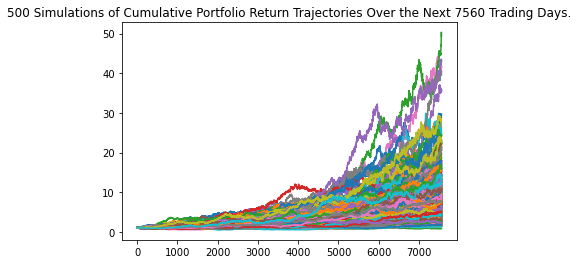

In [23]:
# Plot simulation outcomes
MC_stocks.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

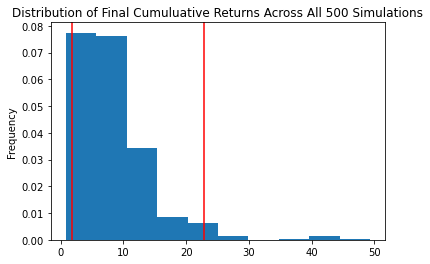

In [24]:
# Plot probability distribution and confidence intervals
MC_stocks.plot_distribution()

### Retirement Analysis

In [25]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_stocks.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              8.250308
std               5.989516
min               0.797395
25%               4.265710
50%               6.913489
75%              10.573717
max              49.352667
95% CI Lower      1.779517
95% CI Upper     22.780193
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [26]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
# YOUR CODE HERE!
ci_lower = round(initial_investment * tbl[8])
ci_upper = round(initial_investment * tbl[9])

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $35590 and $455604


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [27]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(initial_investment * tbl[8])
ci_upper = round(initial_investment * tbl[9])

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $53386 and $683406


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [28]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[.40, .60],
    num_simulation=500,
    num_trading_days=252 * 5
)

In [29]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\range\Documents\Fintech Bootcamp\Week_05_Assignment\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998348,1.005587,0.984619,0.995042,0.988235,1.007025,1.008525,0.999940,0.998315,1.004537,...,1.007838,0.991202,0.991637,1.000895,0.994933,0.993609,0.999219,1.003048,1.009917,1.001395
2,0.998502,0.987225,0.986169,0.977987,0.993974,1.006753,1.000241,1.000239,1.019742,1.004466,...,1.016837,1.003743,0.984780,0.996302,0.999547,1.008021,0.993571,0.989897,1.010447,1.008480
3,0.993870,0.997056,0.983480,0.970873,0.998990,1.002333,1.018554,0.994470,1.019123,1.012596,...,1.012272,0.988901,0.978520,0.996217,1.002483,0.998684,0.974564,0.993695,1.011549,1.002041
4,1.002280,0.992377,0.986786,0.976803,0.993122,1.010609,1.022837,0.998346,1.014958,1.003932,...,1.012705,0.997191,0.976067,0.992340,0.992628,0.984259,0.988665,0.987731,1.004061,0.995726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.026847,1.176866,1.661589,1.430275,1.456326,1.269576,1.137179,1.643088,1.921535,1.166730,...,1.349505,1.430796,1.481578,1.866668,2.053353,1.457892,1.595495,1.944799,1.459841,1.606614
1257,1.026066,1.172176,1.663773,1.422525,1.453150,1.265382,1.140321,1.616651,1.916353,1.173363,...,1.342297,1.429506,1.480336,1.848369,2.036703,1.462165,1.597755,1.954514,1.461888,1.591278
1258,1.043668,1.176556,1.680027,1.423320,1.442972,1.263625,1.135765,1.612185,1.903392,1.171668,...,1.335784,1.432755,1.486719,1.834088,2.041063,1.465094,1.607321,1.940108,1.464932,1.575526
1259,1.054397,1.186072,1.680350,1.438761,1.424392,1.282448,1.143180,1.623527,1.902363,1.183637,...,1.335336,1.431870,1.455549,1.839784,2.033729,1.453805,1.606219,1.956298,1.481149,1.587906


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

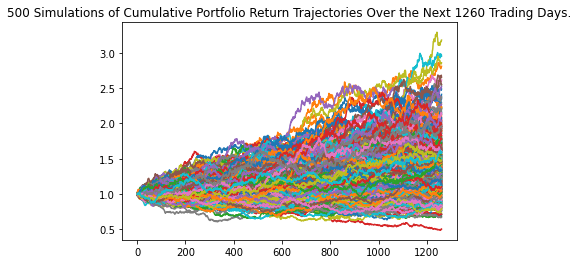

In [30]:
# Plot simulation outcomes
MC_5_year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

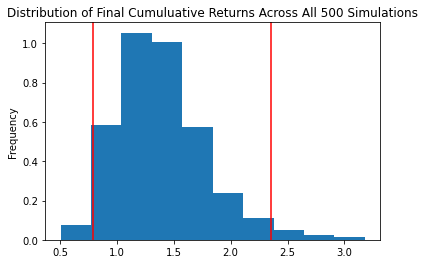

In [31]:
# Plot probability distribution and confidence intervals
MC_5_year.plot_distribution()

In [32]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_5_year = MC_5_year.summarize_cumulative_return()

# Print summary statistics
print(tbl_5_year)

count           500.000000
mean              1.389049
std               0.396977
min               0.504215
25%               1.118373
50%               1.341700
75%               1.609429
max               3.180061
95% CI Lower      0.790744
95% CI Upper      2.355146
Name: 1260, dtype: float64


In [33]:
# Set initial investment
inital_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_5_year = round(initial_investment * tbl_5_year[8])
ci_upper_5_year = round(initial_investment * tbl_5_year[9])

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_5_year} and ${ci_upper_5_year}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 5 years will end within in the range of $23722 and $70654


### Ten Years Retirement Option

In [34]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[.40, .60],
    num_simulation=500,
    num_trading_days=252 * 10
)

In [35]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\range\Documents\Fintech Bootcamp\Week_05_Assignment\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998368,0.986147,1.012697,0.992482,1.003371,0.999399,1.000916,1.006946,0.994379,0.991868,...,1.009302,1.002891,1.001643,0.998552,1.008367,0.998143,0.995558,0.994018,0.999574,1.010880
2,0.991781,0.985833,1.017276,0.980627,1.002696,0.995274,1.002021,1.009931,0.984463,0.991960,...,1.005665,0.990784,0.988860,0.997667,1.005844,1.001752,1.000154,0.998474,0.999033,0.992562
3,0.974543,0.981547,1.020513,0.974657,1.007017,0.987177,0.997232,0.998427,0.975110,1.004437,...,1.003151,0.992103,0.999210,0.994560,0.990991,1.010558,1.001913,0.981117,1.009681,0.977373
4,0.984239,0.985657,1.026255,0.959458,0.983409,0.982251,1.001974,0.999058,0.978553,1.014139,...,1.001082,0.988570,1.003287,0.988128,0.986448,1.026808,1.001226,0.998169,1.010114,0.964448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.581971,1.549047,1.970618,3.385109,1.820121,3.161984,2.441071,1.420155,2.284972,2.197902,...,2.079480,1.037700,1.423111,2.878891,2.596248,1.480819,2.436017,1.786675,2.422035,2.450361
2517,2.601804,1.534195,1.987126,3.412833,1.830689,3.159674,2.431674,1.430180,2.272492,2.197968,...,2.061372,1.045761,1.417291,2.904188,2.583623,1.484410,2.454944,1.808142,2.397054,2.450505
2518,2.555034,1.543697,2.027073,3.430475,1.827123,3.138528,2.417052,1.421959,2.256053,2.188414,...,2.055010,1.061155,1.436809,2.923415,2.571304,1.472144,2.463278,1.812079,2.395482,2.470178
2519,2.561739,1.538441,2.053307,3.452920,1.828223,3.118702,2.420258,1.427818,2.251108,2.225793,...,2.047389,1.055383,1.450207,2.924429,2.571629,1.462537,2.447588,1.814839,2.410487,2.457520


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

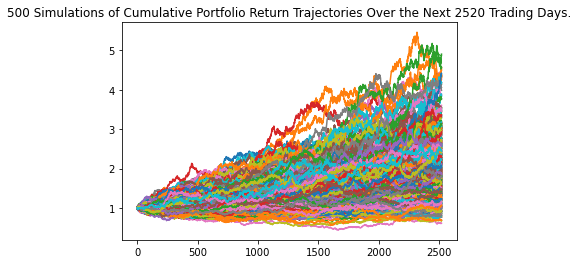

In [36]:
# Plot simulation outcomes
MC_ten_year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

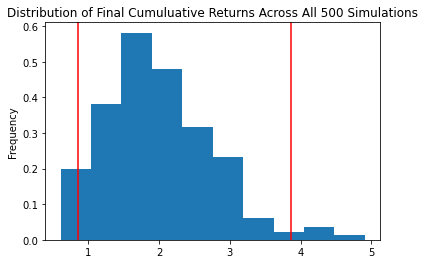

In [37]:
# Plot probability distribution and confidence intervals
MC_ten_year.plot_distribution()

In [38]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_ten_year = MC_ten_year.summarize_cumulative_return()

# Print summary statistics
print(tbl_ten_year)

count           500.000000
mean              2.001296
std               0.758577
min               0.607693
25%               1.468379
50%               1.895773
75%               2.447703
max               4.906882
95% CI Lower      0.853771
95% CI Upper      3.864089
Name: 2520, dtype: float64


In [39]:
# Set initial investment
inital_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten_year = round(initial_investment * tbl_ten_year[8])
ci_upper_ten_year = round(initial_investment * tbl_ten_year[9])

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten_year} and ${ci_upper_ten_year}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 10 years will end within in the range of $25613 and $115923
